# Competition 03 - The Bike Factory Crisis

Management Science - Two-Stage Scheduling Competition

# Client Briefing: Custom Cycles Manufacturing

## Company Background

**Custom Cycles Manufacturing** is a premium bicycle manufacturer based
in Hamburg, Germany. Founded in 1998, they’ve built a reputation for
high-quality custom builds with a loyal customer base of cycling
enthusiasts and professional riders. Annual revenue: 8.5M with 35%
coming from holiday rush orders.

**Your Role:** You’ve been hired as the weekend operations manager to
handle a critical scheduling crisis.

## The Friday Afternoon Crisis

**It’s Friday at 06:00 in the morning.** The production manager just
quit unexpectedly, leaving you with a major problem:

-   **16 custom bicycle orders** received this week - all promised for
    delivery this Friday
-   **2 workstations** available: Assembly Station and Painting Station
-   **Sequential process:** Every bike MUST go through Assembly first,
    then Painting
-   **Skeleton crew:** Staffing is minimal - only one technician per
    station
-   **Cost pressures:**
    -   Overtime costs **€100/hour** for any work after Friday 19:00
        (minute 780)
    -   Late delivery penalties ranging from **€50 to €150 per order**
    -   These are one time fees for missed deadlines, the bikes still
        have to be completed till saturday morning as customers with
        missed deadlines will collect them then

**CEO’s Message:** “We can’t afford to lose these customers before the
holiday season. Figure out the optimal schedule and minimize our costs.
Our reputation depends on it!”

# Data Access & Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set random seed for reproducibility
np.random.seed(2025)

print("Libraries loaded! Ready to tackle the bike factory crisis.")

Libraries loaded! Ready to tackle the bike factory crisis.

## Competition Orders

In [2]:
# DON'T MODIFY THIS DATA - These are your actual orders!
bike_orders = [
    {'id': 'B01', 'type': 'Standard', 'assembly': 45, 'painting': 30, 'due': 480, 'penalty': 50},
    {'id': 'B02', 'type': 'Rush', 'assembly': 60, 'painting': 45, 'due': 360, 'penalty': 150},
    {'id': 'B03', 'type': 'Standard', 'assembly': 30, 'painting': 25, 'due': 540, 'penalty': 50},
    {'id': 'B04', 'type': 'Rush', 'assembly': 50, 'painting': 40, 'due': 300, 'penalty': 150},
    {'id': 'B05', 'type': 'Custom', 'assembly': 90, 'painting': 60, 'due': 720, 'penalty': 100},
    {'id': 'B06', 'type': 'Standard', 'assembly': 40, 'painting': 30, 'due': 600, 'penalty': 50},
    {'id': 'B07', 'type': 'Rush', 'assembly': 35, 'painting': 25, 'due': 240, 'penalty': 150},
    {'id': 'B08', 'type': 'Standard', 'assembly': 55, 'painting': 35, 'due': 660, 'penalty': 50},
    {'id': 'B09', 'type': 'Custom', 'assembly': 75, 'painting': 50, 'due': 640, 'penalty': 100},
    {'id': 'B10', 'type': 'Standard', 'assembly': 45, 'painting': 30, 'due': 520, 'penalty': 50},
    {'id': 'B11', 'type': 'Rush', 'assembly': 40, 'painting': 35, 'due': 280, 'penalty': 150},
    {'id': 'B12', 'type': 'Standard', 'assembly': 50, 'painting': 40, 'due': 580, 'penalty': 50},
    {'id': 'B13', 'type': 'Custom', 'assembly': 85, 'painting': 55, 'due': 780, 'penalty': 100},
    {'id': 'B14', 'type': 'Rush', 'assembly': 45, 'painting': 30, 'due': 320, 'penalty': 150},
    {'id': 'B15', 'type': 'Standard', 'assembly': 35, 'painting': 25, 'due': 640, 'penalty': 50},
    {'id': 'B16', 'type': 'Standard', 'assembly': 60, 'painting': 45, 'due': 700, 'penalty': 50}
]

# Convert to DataFrame for analysis
df_bikes = pd.DataFrame(bike_orders)

print("Custom Cycles - Rush Orders")
print("=" * 50)
print(f"Total orders: {len(df_bikes)}")
print(f"\nOrder breakdown by type:")
print(df_bikes['type'].value_counts().to_string())
print(f"\nWorkload analysis:")
print(f"  Total assembly time: {df_bikes['assembly'].sum()} minutes ({df_bikes['assembly'].sum()/60:.1f} hours)")
print(f"  Total painting time: {df_bikes['painting'].sum()} minutes ({df_bikes['painting'].sum()/60:.1f} hours)")
print(f"  Average assembly: {df_bikes['assembly'].mean():.1f} minutes")
print(f"  Average painting: {df_bikes['painting'].mean():.1f} minutes")
print(f"\nTime constraints:")
print(f"  Work starts: Friday 6:00 (minute 0)")
print(f"  Regular hours end: Friday 19:00 (minute 780)")
print(f"  Overtime rate: €100/hour after minute 780")
print(f"\nPenalty exposure:")
print(f"  Total if ALL orders late: €{df_bikes['penalty'].sum():,}")
# DON'T MODIFY ABOVE!

Custom Cycles - Rush Orders
Total orders: 16

Order breakdown by type:
type
Standard    8
Rush        5
Custom      3

Workload analysis:
  Total assembly time: 840 minutes (14.0 hours)
  Total painting time: 600 minutes (10.0 hours)
  Average assembly: 52.5 minutes
  Average painting: 37.5 minutes

Time constraints:
  Work starts: Friday 6:00 (minute 0)
  Regular hours end: Friday 19:00 (minute 780)
  Overtime rate: €100/hour after minute 780

Penalty exposure:
  Total if ALL orders late: €1,450

## Initial Data Exploration

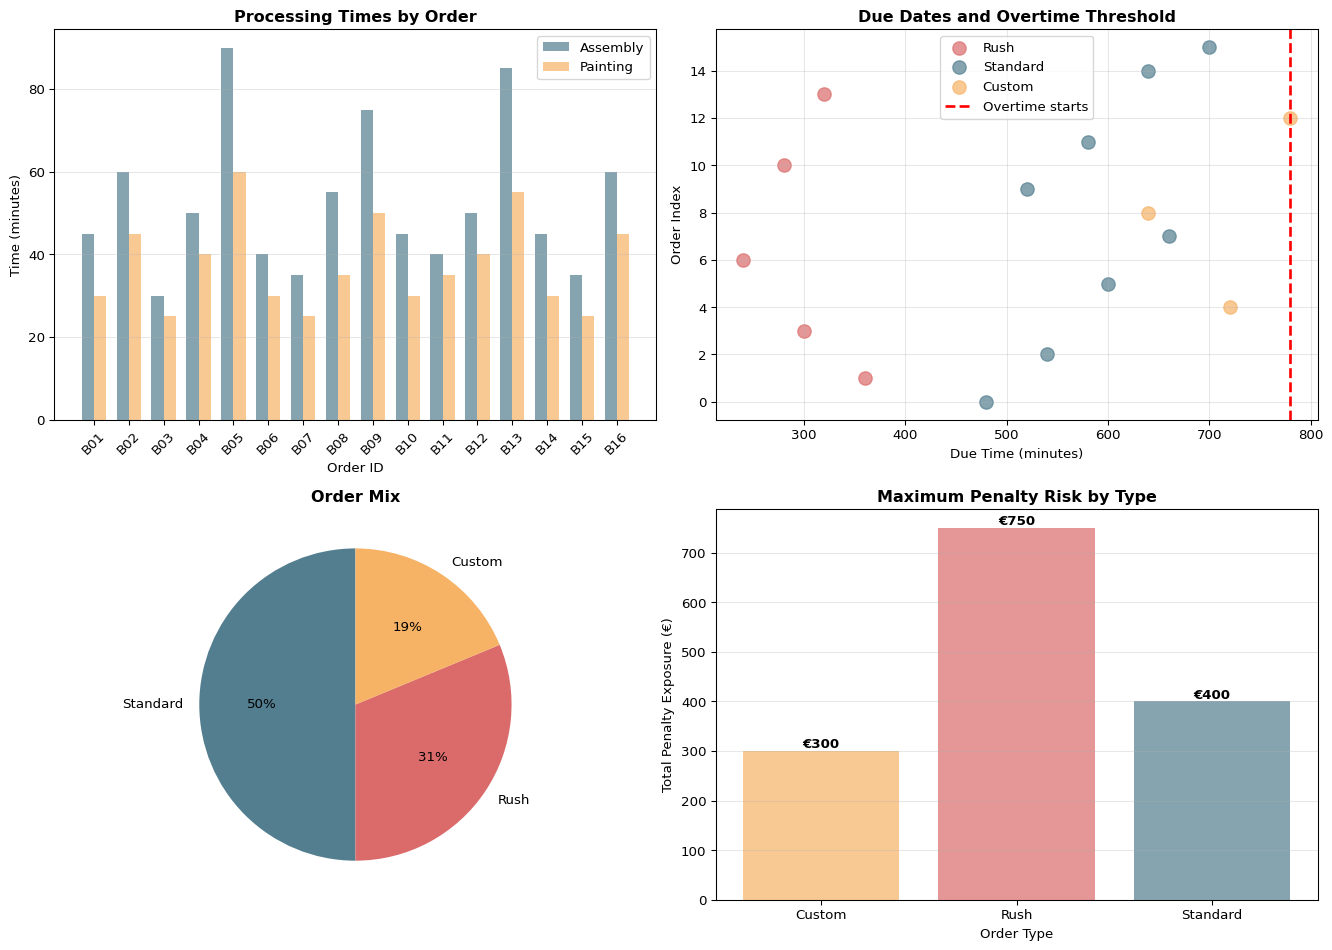


Key Insights:
  - Tightest deadline: Order B07 (due at 240 min)
  - Longest processing: Order B05 (150 min total)
  - Rush orders have 3x higher penalties

In [3]:
# Visualize order characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Processing times by order
ax = axes[0, 0]
x = np.arange(len(df_bikes))
width = 0.35
ax.bar(x - width/2, df_bikes['assembly'], width, label='Assembly', color='#537E8F', alpha=0.7)
ax.bar(x + width/2, df_bikes['painting'], width, label='Painting', color='#F6B265', alpha=0.7)
ax.set_xlabel('Order ID')
ax.set_ylabel('Time (minutes)')
ax.set_title('Processing Times by Order', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_bikes['id'], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Due dates timeline
ax = axes[0, 1]
colors = {'Rush': '#DB6B6B', 'Standard': '#537E8F', 'Custom': '#F6B265'}
for order_type in ['Rush', 'Standard', 'Custom']:
    subset = df_bikes[df_bikes['type'] == order_type]
    ax.scatter(subset['due'], subset.index, label=order_type,
              color=colors[order_type], s=100, alpha=0.7)
ax.axvline(x=780, color='red', linestyle='--', label='Overtime starts', linewidth=2)
ax.set_xlabel('Due Time (minutes)')
ax.set_ylabel('Order Index')
ax.set_title('Due Dates and Overtime Threshold', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Order type distribution
ax = axes[1, 0]
type_counts = df_bikes['type'].value_counts()
colors_pie = [colors[t] for t in type_counts.index]
ax.pie(type_counts.values, labels=type_counts.index, autopct='%1.0f%%',
       colors=colors_pie, startangle=90)
ax.set_title('Order Mix', fontweight='bold')

# 4. Penalty distribution
ax = axes[1, 1]
penalty_by_type = df_bikes.groupby('type')['penalty'].agg(['sum', 'mean', 'count'])
x_pos = np.arange(len(penalty_by_type))
ax.bar(x_pos, penalty_by_type['sum'], color=[colors[t] for t in penalty_by_type.index], alpha=0.7)
ax.set_xlabel('Order Type')
ax.set_ylabel('Total Penalty Exposure (€)')
ax.set_title('Maximum Penalty Risk by Type', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(penalty_by_type.index)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(penalty_by_type['sum']):
    ax.text(i, v, f'€{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Tightest deadline: Order {df_bikes.loc[df_bikes['due'].idxmin(), 'id']} (due at {df_bikes['due'].min()} min)")
print(f"  - Longest processing: Order {df_bikes.loc[(df_bikes['assembly']+df_bikes['painting']).idxmax(), 'id']} ({(df_bikes['assembly']+df_bikes['painting']).max()} min total)")
print(f"  - Rush orders have {df_bikes[df_bikes['type']=='Rush']['penalty'].iloc[0]/df_bikes[df_bikes['type']=='Standard']['penalty'].iloc[0]:.0f}x higher penalties")

# Starter Code & Helper Functions

In [4]:
def calculate_schedule_cost(schedule, overtime_threshold=780, overtime_rate_per_min=100/60):
    """
    Calculate total cost for a given schedule

    Parameters:
    - schedule: list of orders with completion times
    - overtime_threshold: minute when overtime starts (default 780)
    - overtime_rate_per_min: cost per minute of overtime (default €1.67/min)

    Returns:
    - Dictionary with cost breakdown
    """
    total_overtime_cost = 0
    total_penalty_cost = 0
    late_orders = []

    for order in schedule:
        # Check for overtime (based on painting end time)
        if order['painting_end'] > overtime_threshold:
            overtime_minutes = order['painting_end'] - overtime_threshold
            overtime_cost = overtime_minutes * overtime_rate_per_min
            total_overtime_cost += overtime_cost

        # Check for late delivery
        if order['completion'] > order['due']:
            total_penalty_cost += order['penalty']
            late_orders.append(order['id'])

    return {
        'total_cost': total_overtime_cost + total_penalty_cost,
        'overtime_cost': total_overtime_cost,
        'penalty_cost': total_penalty_cost,
        'late_count': len(late_orders),
        'late_orders': late_orders
    }

def two_stage_schedule(orders, sequence):
    """
    Schedule orders through assembly and painting stations

    Parameters:
    - orders: list of order dictionaries
    - sequence: list of order IDs in desired processing order

    Returns:
    - scheduled_orders: list with start/end times added
    """
    # Create a copy and reorder based on sequence
    order_dict = {o['id']: o.copy() for o in orders}
    scheduled_orders = [order_dict[oid] for oid in sequence]

    assembly_time = 0
    painting_time = 0

    for order in scheduled_orders:
        # Assembly station (starts immediately when available)
        order['assembly_start'] = assembly_time
        order['assembly_end'] = assembly_time + order['assembly']
        assembly_time = order['assembly_end']

        # Painting station (must wait for both: painting available AND assembly done)
        order['painting_start'] = max(painting_time, order['assembly_end'])
        order['painting_end'] = order['painting_start'] + order['painting']
        painting_time = order['painting_end']

        # Overall completion is when painting finishes
        order['completion'] = order['painting_end']

    return scheduled_orders

print("Helper functions loaded!")
print("\nAvailable functions:")
print("  - calculate_schedule_cost(schedule) → cost breakdown")
print("  - two_stage_schedule(orders, sequence) → scheduled orders with times")

Helper functions loaded!

Available functions:
  - calculate_schedule_cost(schedule) → cost breakdown
  - two_stage_schedule(orders, sequence) → scheduled orders with times

## Example: Testing a Simple Schedule

In [5]:
# Example: Schedule in original order (FIFO approach)
print("Example: FIFO Schedule (Original Order)")

# Create sequence in original order
fifo_sequence = [o['id'] for o in bike_orders]
print(f"Order sequence: {fifo_sequence}")

# Schedule the orders (function just takes the schedule created)
# Hint: Print `fifo_sequence` to see what's expected for the function to work
fifo_schedule = two_stage_schedule(bike_orders, fifo_sequence)

# Calculate costs (this)
fifo_costs = calculate_schedule_cost(fifo_schedule)

print(f"\nResults:")
print(f"  Total Cost: €{fifo_costs['total_cost']:.2f}")
print(f"  Breakdown:")
print(f"    - Overtime: €{fifo_costs['overtime_cost']:.2f}")
print(f"    - Penalties: €{fifo_costs['penalty_cost']:.2f}")
print(f"  Late orders: {fifo_costs['late_count']} out of {len(bike_orders)}")
print(f"  Final completion: {fifo_schedule[-1]['completion']} minutes ({fifo_schedule[-1]['completion']/60:.1f} hours)")

print("\nThis is just ONE possible schedule. Can you do better?")

Example: FIFO Schedule (Original Order)
Order sequence: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16']

Results:
  Total Cost: €883.33
  Breakdown:
    - Overtime: €233.33
    - Penalties: €650.00
  Late orders: 7 out of 16
  Final completion: 885 minutes (14.8 hours)

This is just ONE possible schedule. Can you do better?

# Your Task

## Step 1: Understand the Problem

Before coding, think through these questions:

-   What makes a “good” schedule for this problem?
-   How does the two-stage constraint affect your choices?

## Step 2: Implement Different Scheduling Rules

Try multiple approaches and compare them to select the best one.

In [6]:
# YOUR SOLUTION HERE

## Step 3: Visualize Your Best Solution

In [7]:
# Create Gantt chart for your best solution
# YOUR SOLUTION HERE

## Step 4: Create Your Submission

Prepare a one-slide presentation (PDF) containing:

-   **Your Best Schedule:** Total cost achieved (prominently displayed)
-   **Approach:** Which scheduling rule(s) did you use?
-   **Gantt Chart:** Visual showing your two-stage schedule (optional
    but recommended)
-   **Cost Breakdown:** Overtime vs. penalties
-   **Strategy Justification:** 2-3 sentences explaining why your
    approach works

# Tips for Success

## Strategy Suggestions

1.  **Start with Simple Rules:** Get FIFO and EDD working first
2.  **Understand Two-Stage Logic:** The painting station often has idle
    time - that’s normal!
3.  **Consider Trade-offs:** Sometimes accepting overtime prevents
    expensive penalties
4.  **Johnson’s Algorithm:** It minimizes makespan, but that might not
    minimize costs!
5.  **Custom Rules:** Think about penalty-weighted priorities or hybrid
    approaches

## Common Pitfalls to Avoid

-   **Forgetting the two-stage constraint:** Painting MUST wait for
    assembly to finish
-   **Overtime calculation:** Only count minutes AFTER 1800, not total
    time
-   **Penalty logic:** Only charge penalties if completion \> due time
-   **Ignoring order types:** Rush orders have 3x the penalty of
    standard orders!

## Final Checklist

-   [ ] All bikes scheduled through both stations
-   [ ] Painting never starts before assembly ends
-   [ ] No negative times
-   [ ] Overtime only charged after minute 1800
-   [ ] Penalties only for late orders (completion \> due)
-   [ ] Total cost = overtime + penalties

# Good Luck!